In [3]:
!git clone https://github.com/lollcat/fab-torch.git
%cd fab-torch
!pip install --upgrade .

Cloning into 'fab-torch'...
remote: Enumerating objects: 3496, done.
remote: Counting objects: 100% (420/420), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 3496 (delta 252), reused 262 (delta 222), pack-reused 3076 (from 1)
Receiving objects: 100% (3496/3496), 272.53 MiB | 19.18 MiB/s, done.
Resolving deltas: 100% (2510/2510), done.
/content/fab-torch
Processing /content/fab-torch
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/VincentStimper/boltzmann-generators.git to /tmp/pip-install-pbudef1e/boltzgen_ee4ee0888cab4a6787758c142cd98434
  Running command git clone --filter=blob:none --quiet https://github.com/VincentStimper/boltzmann-generators.git /tmp/pip-install-pbudef1e/boltzgen_ee4ee0888cab4a6787758c142cd98434
  Resolved https://github.com/VincentStimper/boltzmann-generators.git to commit 2b177fc155f533933489b8fce8d6483ebad250d3
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/VincentStimper/resampled-base-flows.

In [4]:
! pip install -q torchcfm einops dm-tree

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 901.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
import copy

import tree
import torch
import numpy as np
import matplotlib.pyplot as plt

from torchcfm.conditional_flow_matching import pad_t_like_x
from torchcfm.utils import sample_8gaussians, torch_wrapper, plot_trajectories, sample_moons
from torchcfm.models.models import MLP
from torchdyn.core import NeuralODE
from tqdm.auto import tqdm
from fab.target_distributions.gmm import GMM

In [6]:
#@title MLP Source Code
import copy

import numpy as np
import torch
from einops import rearrange
from torch import nn
from torch.nn import functional as F
from torch.nn.utils import spectral_norm


class SinusoidalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        half_size = self.size // 2
        emb = torch.log(torch.Tensor([10000.0]).to(x.device)) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size).to(x.device))
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

    def __len__(self):
        return self.size


class LinearEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x / self.size * self.scale
        return x.unsqueeze(-1)

    def __len__(self):
        return 1


class LearnableEmbedding(nn.Module):
    def __init__(self, size: int):
        super().__init__()
        self.size = size
        self.linear = nn.Linear(1, size)

    def forward(self, x: torch.Tensor):
        return self.linear(x.unsqueeze(-1).float() / self.size)

    def __len__(self):
        return self.size


class IdentityEmbedding(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor):
        return x.unsqueeze(-1)

    def __len__(self):
        return 1


class ZeroEmbedding(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor):
        return x.unsqueeze(-1) * 0

    def __len__(self):
        return 1


class PositionalEmbedding(nn.Module):
    def __init__(self, size: int, type: str, **kwargs):
        super().__init__()

        if type == "sinusoidal":
            self.layer = SinusoidalEmbedding(size, **kwargs)
        elif type == "linear":
            self.layer = LinearEmbedding(size, **kwargs)
        elif type == "learnable":
            self.layer = LearnableEmbedding(size)
        elif type == "zero":
            self.layer = ZeroEmbedding()
        elif type == "identity":
            self.layer = IdentityEmbedding()
        else:
            raise ValueError(f"Unknown positional embedding type: {type}")

    def forward(self, x: torch.Tensor):
        return self.layer(x)


class Block(nn.Module):
    def __init__(self, size: int, t_emb_size: int = 0, add_t_emb=False, concat_t_emb=False):
        super().__init__()

        in_size = size + t_emb_size if concat_t_emb else size
        self.ff = nn.Linear(in_size, size)
        self.act = nn.GELU()

        self.add_t_emb = add_t_emb
        self.concat_t_emb = concat_t_emb

    def forward(self, x: torch.Tensor, t_emb: torch.Tensor):
        in_arg = torch.cat([x, t_emb], dim=-1) if self.concat_t_emb else x
        out = x + self.act(self.ff(in_arg))

        if self.add_t_emb:
            out = out + t_emb

        return out


class FourierMLP(nn.Module):
    def __init__(
        self,
        in_shape=2,
        out_shape=2,
        num_layers=2,
        channels=128,
        zero_init=True,
        energy_function=None,
    ):
        super().__init__()

        self.in_shape = (in_shape,)
        self.out_shape = (out_shape,)

        self.register_buffer(
            "timestep_coeff", torch.linspace(start=0.1, end=100, steps=channels)[None]
        )
        self.timestep_phase = nn.Parameter(torch.randn(channels)[None])
        self.input_embed = nn.Linear(int(np.prod(in_shape)), channels)
        self.timestep_embed = nn.Sequential(
            nn.Linear(2 * channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )
        self.layers = nn.Sequential(
            nn.GELU(),
            *[nn.Sequential(nn.Linear(channels, channels), nn.GELU()) for _ in range(num_layers)],
            nn.Linear(channels, int(np.prod(self.out_shape))),
        )
        if zero_init:
            self.layers[-1].weight.data.fill_(0.0)
            self.layers[-1].bias.data.fill_(0.0)

    def forward(self, cond, inputs):
        cond = cond.view(-1, 1).expand((inputs.shape[0], 1))
        sin_embed_cond = torch.sin((self.timestep_coeff * cond.float()) + self.timestep_phase)
        cos_embed_cond = torch.cos((self.timestep_coeff * cond.float()) + self.timestep_phase)
        embed_cond = self.timestep_embed(
            rearrange([sin_embed_cond, cos_embed_cond], "d b w -> b (d w)")
        )
        embed_ins = self.input_embed(inputs.view(inputs.shape[0], -1))
        out = self.layers(embed_ins + embed_cond)
        return out.view(-1, *self.out_shape)


class TimeConder(nn.Module):
    def __init__(self, channel, out_dim, num_layers):
        super().__init__()
        self.register_buffer(
            "timestep_coeff", torch.linspace(start=0.1, end=100, steps=channel)[None]
        )
        self.timestep_phase = nn.Parameter(torch.randn(channel)[None])
        self.layers = nn.Sequential(
            nn.Linear(2 * channel, channel),
            *[
                nn.Sequential(
                    nn.GELU(),
                    nn.Linear(channel, channel),
                )
                for _ in range(num_layers - 1)
            ],
            nn.GELU(),
            nn.Linear(channel, out_dim),
        )

        self.layers[-1].weight.data.fill_(0.0)
        self.layers[-1].bias.data.fill_(0.01)

    def forward(self, t):
        if t.ndim < self.timestep_coeff.ndim:
            t = t.unsqueeze(-1)
        sin_cond = torch.sin((self.timestep_coeff * t.float()) + self.timestep_phase)
        cos_cond = torch.cos((self.timestep_coeff * t.float()) + self.timestep_phase)
        cond = rearrange([sin_cond, cos_cond], "d b w -> b (d w)")
        return self.layers(cond)


class MyMLP(nn.Module):
    def __init__(
        self,
        hidden_size: int = 128,
        hidden_layers: int = 3,
        emb_size: int = 128,
        out_dim: int = 2,
        time_emb: str = "sinusoidal",
        input_emb: str = "sinusoidal",
        add_t_emb: bool = False,
        concat_t_emb: bool = False,
        input_dim: int = 2,
        energy_function=None,
    ):
        super().__init__()

        self.add_t_emb = add_t_emb
        self.concat_t_emb = concat_t_emb

        self.time_mlp = PositionalEmbedding(emb_size, time_emb)

        positional_embeddings = []
        for i in range(input_dim):
            embedding = PositionalEmbedding(emb_size, input_emb, scale=25.0)

            self.add_module(f"input_mlp{i}", embedding)

            positional_embeddings.append(embedding)

        self.channels = 1
        self.self_condition = False
        concat_size = len(self.time_mlp.layer) + sum(
            map(lambda x: len(x.layer), positional_embeddings)
        )

        layers = [nn.Linear(concat_size, hidden_size)]
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size, emb_size, add_t_emb, concat_t_emb))

        in_size = emb_size + hidden_size if concat_t_emb else emb_size
        layers.append(nn.Linear(in_size, out_dim))

        self.layers = layers
        self.joint_mlp = nn.Sequential(*layers)

    def forward(self, t, x, x_self_cond=False):
        positional_embs = [
            self.get_submodule(f"input_mlp{i}")(x[:, i]) for i in range(x.shape[-1])
        ]

        t_emb = self.time_mlp(t.squeeze())
        x = torch.cat((*positional_embs, t_emb), dim=-1)

        for i, layer in enumerate(self.layers):
            if i == 0:
                x = nn.GELU()(layer(x))
                if self.add_t_emb:
                    x = x + t_emb

            elif i == len(self.layers) - 1:
                if self.concat_t_emb:
                    x = torch.cat([x, t_emb], dim=-1)

                x = layer(x)

            else:
                x = layer(x, t_emb)

        return x


class MyMLPNoSpaceEmbedding(nn.Module):
    def __init__(
        self,
        hidden_size: int = 128,
        hidden_layers: int = 3,
        emb_size: int = 128,
        out_dim: int = 2,
        time_emb: str = "sinusoidal",
        input_emb: str = "sinusoidal",
        add_t_emb: bool = False,
        concat_t_emb: bool = False,
    ):
        super().__init__()

        self.add_t_emb = add_t_emb
        self.concat_t_emb = concat_t_emb

        self.time_mlp = PositionalEmbedding(emb_size, time_emb)
        self.channels = 1
        self.self_condition = False
        concat_size = len(self.time_mlp.layer) + 2
        layers = [nn.Linear(concat_size, hidden_size)]
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size, emb_size, add_t_emb, concat_t_emb))

        in_size = emb_size + hidden_size if concat_t_emb else emb_size
        layers.append(nn.Linear(in_size, out_dim))

        self.layers = layers
        self.joint_mlp = nn.Sequential(*layers)

    def forward(self, t, x, x_self_cond=False):
        t_emb = self.time_mlp(t.squeeze())
        x = torch.cat((x, t_emb), dim=-1)

        for i, layer in enumerate(self.layers):
            if i == 0:
                x = nn.GELU()(layer(x))
                if self.add_t_emb:
                    x = x + t_emb

            elif i == len(self.layers) - 1:
                if self.concat_t_emb:
                    x = torch.cat([x, t_emb], dim=-1)

                x = layer(x)

            else:
                x = layer(x, t_emb)

        return x


class MyMLPNoEmbedding(nn.Module):
    def __init__(
        self,
        hidden_size: int = 128,
        hidden_layers: int = 3,
        emb_size: int = 128,
        out_dim: int = 2,
        time_emb: str = "sinusoidal",
        input_emb: str = "sinusoidal",
        add_t_emb: bool = False,
        concat_t_emb: bool = False,
    ):
        super().__init__()

        self.add_t_emb = add_t_emb
        self.concat_t_emb = concat_t_emb

        emb_size = 1
        self.time_mlp = PositionalEmbedding(emb_size, time_emb)
        self.channels = 1
        self.self_condition = False
        concat_size = 3
        layers = [nn.Linear(concat_size, hidden_size)]
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size, emb_size, add_t_emb, concat_t_emb))

        in_size = emb_size + hidden_size if concat_t_emb else emb_size
        layers.append(nn.Linear(in_size, out_dim))

        self.layers = layers
        self.joint_mlp = nn.Sequential(*layers)

    def forward(self, t, x, x_self_cond=False):
        # t_emb = self.time_mlp(t.squeeze())
        t_emb = t.unsqueeze(1)
        x = torch.cat((x, t_emb), dim=-1)

        for i, layer in enumerate(self.layers):
            if i == 0:
                x = nn.GELU()(layer(x))
                if self.add_t_emb:
                    x = x + t_emb

            elif i == len(self.layers) - 1:
                if self.concat_t_emb:
                    x = torch.cat([x, t_emb], dim=-1)

                x = layer(x)

            else:
                x = layer(x, t_emb)

        return x


class MyMLP6dim(nn.Module):
    def __init__(
        self,
        hidden_size: int = 128,
        hidden_layers: int = 3,
        emb_size: int = 128,
        time_emb: str = "sinusoidal",
        input_emb: str = "sinusoidal",
    ):
        super().__init__()

        self.time_mlp = PositionalEmbedding(emb_size, time_emb)
        self.input_mlp1 = PositionalEmbedding(emb_size, input_emb, scale=25.0)
        self.input_mlp2 = PositionalEmbedding(emb_size, input_emb, scale=25.0)
        self.input_mlp3 = PositionalEmbedding(emb_size, input_emb, scale=25.0)
        self.input_mlp4 = PositionalEmbedding(emb_size, input_emb, scale=25.0)
        self.input_mlp5 = PositionalEmbedding(emb_size, input_emb, scale=25.0)
        self.input_mlp6 = PositionalEmbedding(emb_size, input_emb, scale=25.0)

        self.channels = 1
        self.self_condition = False
        concat_size = (
            len(self.time_mlp.layer)
            + len(self.input_mlp1.layer)
            + len(self.input_mlp2.layer)
            + len(self.input_mlp3.layer)
            + len(self.input_mlp4.layer)
            + len(self.input_mlp5.layer)
            + len(self.input_mlp6.layer)
        )
        layers = [nn.Linear(concat_size, hidden_size), nn.GELU()]
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size))
        layers.append(nn.Linear(hidden_size, 6))
        self.joint_mlp = nn.Sequential(*layers)

    def forward(self, t, x, x_self_cond=False):
        x1_emb = self.input_mlp1(x[:, 0])
        x2_emb = self.input_mlp2(x[:, 1])
        x3_emb = self.input_mlp3(x[:, 2])
        x4_emb = self.input_mlp4(x[:, 3])
        x5_emb = self.input_mlp5(x[:, 4])
        x6_emb = self.input_mlp6(x[:, 5])
        t_emb = self.time_mlp(t.squeeze())
        x = torch.cat((x1_emb, x2_emb, x3_emb, x4_emb, x5_emb, x6_emb, t_emb), dim=-1)
        x = self.joint_mlp(x)
        return x


class SpectralNormMLP(nn.Module):
    def __init__(
        self,
        input_size: int = 2,
        hidden1_size: int = 64,
        hidden2_size: int = 128,
        output_size: int = 1,
    ):
        super().__init__()

        # First hidden layer with spectral normalization
        self.fc1 = spectral_norm(nn.Linear(input_size, hidden1_size))

        # Second hidden layer with spectral normalization
        self.fc2 = spectral_norm(nn.Linear(hidden1_size, hidden2_size))

        # Output layer with spectral normalization
        self.fc3 = spectral_norm(nn.Linear(hidden2_size, output_size))

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Setup Target Distribution

In [7]:
dim = 2
n_mixes = 40
loc_scaling = 40.0  # scale of the problem (changes how far apart the modes of each Guassian component will be)
log_var_scaling = 1.0 # variance of each Gaussian
seed = 0

In [8]:
torch.manual_seed(0)  # seed of 0 for GMM problem
target = GMM(dim=dim, n_mixes=n_mixes,
              loc_scaling=loc_scaling, log_var_scaling=log_var_scaling,
              use_gpu=True, true_expectation_estimation_n_samples=int(1e5))

## Flow matching with gaussian prior using samples

In [9]:
def ema_update(model, ema_model, alpha=0.999):
    state_dict = model.state_dict()
    ema_state_dict = ema_model.state_dict()

    ema_state_dict = tree.map_structure(
        lambda x, y: alpha*x + (1-alpha)*y,
        ema_state_dict, state_dict,
    )
    ema_model.load_state_dict(ema_state_dict)

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
dim = 2
batch_size = 256
total_steps = 20000
model = MyMLP(input_dim=dim, out_dim=dim, hidden_size=128, hidden_layers=3)
model.to(device)

ema_model = copy.deepcopy(model)

optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.001,
    total_steps=total_steps,
    anneal_strategy="linear",
)

sigma = 0.00001
pbar = tqdm(range(total_steps))

losses = []

for k in pbar:
    optimizer.zero_grad()

    x1 = target.sample(shape=(batch_size,)).to(device)
    t = torch.rand(batch_size, device=device)
    t = torch.clip(t, min=0.01, max=1)
    t = pad_t_like_x(t, x1)

    xt = t*x1 + (t*sigma - t + 1) * torch.randn(batch_size, dim, device=device)
    ut = (x1 - (1 - sigma)*xt) / (1 - (1 - sigma)*t)

    vt = model(t, xt)
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()
    scheduler.step()
    ema_update(model, ema_model)

    pbar.set_postfix({"Loss": loss.item()})
    losses.append(loss.item())

pbar.close()

  0%|          | 0/20000 [00:00<?, ?it/s]

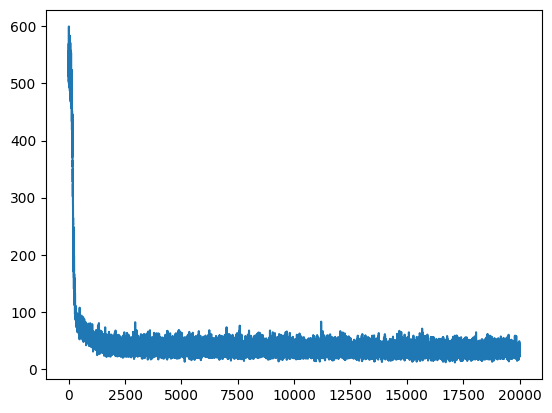

In [11]:
plt.plot(losses)
plt.show()

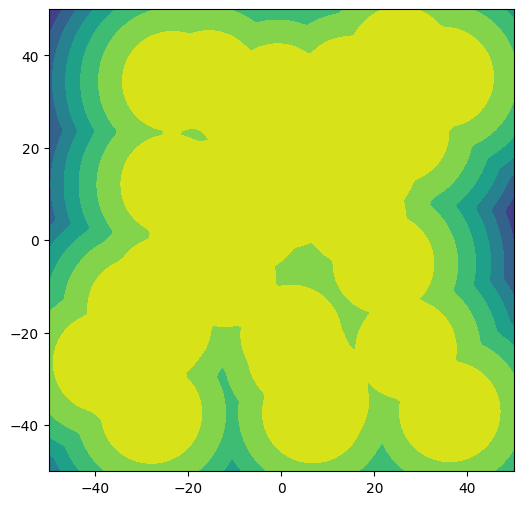

In [12]:
def reward_function(x):
    x = torch.asarray(x, device=device)
    e = target.log_prob(x)
    return e

x = torch.linspace(-50, 50, 100)
y = torch.linspace(-50, 50, 100)

X, Y = torch.meshgrid(x, y, indexing='ij')
Z = reward_function(torch.stack([X, Y], dim=-1).to(device)).cpu()

plt.figure(figsize=(6, 6))
plt.contourf(X, Y, Z)
plt.show()

In [13]:
# Generate samples
num_samples = 4000
dt = 0.01

x0 = torch.randn(num_samples, dim).to(device)
xt = x0

for t in np.arange(0, 1, dt):
    t = torch.ones(num_samples, 1) * t
    t = t.to(device)

    with torch.no_grad():
        vt = ema_model(t, xt)

    xt = xt + vt * dt

x1 = xt
nll = -target.log_prob(x1)

nll.mean()

tensor(8.4729, device='cuda:0')

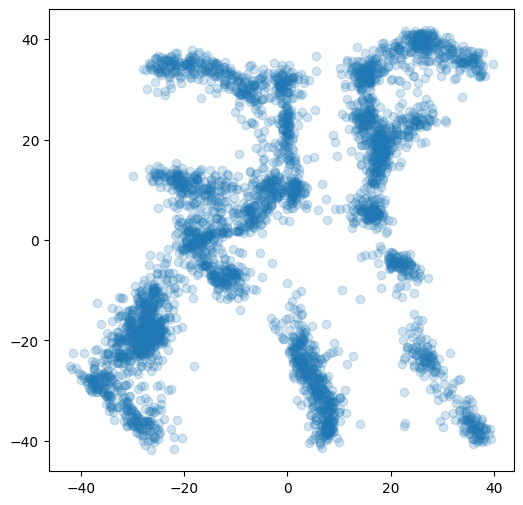

In [14]:
x, y = x1.cpu().unbind(dim=1)

plt.figure(figsize=(6, 6))
plt.scatter(x, y, alpha=0.2)
plt.show()